# training model to predict for each minuite the score
continuous labels in [-1, 1].
onset=1, wakeup = -1 and a composite score over a window of 30 minuites before and after


# Preparing data for the models

In [ ]:
# import requirements

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from concurrent.futures import ProcessPoolExecutor

In [ ]:
# read preprocessed buckets

buckets_path = "processed_data/buckets_for_picks_prediction_model.parquet"
buckets = pd.read_parquet(buckets_path)
buckets

,series_id,bucket,step,worn,hour,enmo,enmo_std,anglez_log,anglez_std,anglez_value_counts,target,anglez_log_ewma,enmo_ewma
0,038441c925bb,2018-08-14,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, ...",1,"[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...","[-0.16349883, -0.1931289, -0.25024912, -0.3244...","[-0.4392864, -0.27086866, -0.08205997, -0.4434...","[0.6985727, 1.0362152, -0.3485857, -2.2371774,...","[-0.70323086, 1.7682015, 3.7148108, -0.7146914...","[4, 5, 3, 3, 2, 1, 2, 2, 2, 1, 2, 2, 2, 8, 7, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.87253032818905, 1.0891742536778797, 0.54940...","[-0.26692548136100913, -0.2915036204859992, -0..."
1,038441c925bb,2018-08-15,"[16200, 16212, 16224, 16236, 16248, 16260, 162...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.5445473, -0.5384195, -0.55367094, 2.207655...","[-0.3984071, -0.43412158, -0.40988225, 2.16966...","[-1.1600173, -1.0104151, -1.0199851, 0.0843932...","[-0.7463166, -0.8548056, -0.8091363, 0.5429577...","[3, 2, 2, 6, 2, 4, 2, 1, 3, 1, 1, 3, 2, 2, 9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.9347463538710923, -1.8052268870075403, -1....","[-0.8166037670768754, -0.8118206280960815, -0...."
2,038441c925bb,2018-08-16,"[33480, 33492, 33504, 33516, 33528, 33540, 335...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.23109697, 0.09120488, 0.033813287, 0.026639...","[-0.20623524, -0.11359837, -0.052542243, -0.14...","[-0.008634078, 0.08142903, 0.30459088, 0.27667...","[1.3266863, 1.6417787, 1.327748, 1.3931719, 2....","[5, 2, 2, 2, 2, 1, 2, 10, 6, 2, 2, 5, 7, 2, 1,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.012038710129515684, 0.0613677671531428, 0....","[0.4748477605776372, 0.3245841466999011, 0.232..."
3,038441c925bb,2018-08-17,"[50760, 50772, 50784, 50796, 50808, 50820, 508...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.2527756, 1.1799846, 1.5040432, 5.1157236, ...","[0.28345567, 1.0553511, 1.8320727, 4.9168553, ...","[0.15004267, 0.43735644, 0.38528717, 0.5604871...","[-0.24063708, -0.0013753887, 0.13565959, 0.492...","[4, 5, 2, 1, 5, 6, 1, 5, 2, 2, 2, 2, 2, 2, 2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.22597487040083097, 0.4316607742666523, 0.47...","[-0.4886070050651297, 0.9160947103060656, 1.60..."
4,038441c925bb,2018-08-19,"[85320, 85332, 85344, 85356, 85368, 85380, 853...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[1.6512856, 1.8624821, 0.9738643, 2.1458478, 0...","[0.90756637, 0.44645062, 0.3423575, 0.84843844...","[0.44042394, 0.48366603, 0.49500227, 0.4920682...","[-0.6051638, -0.38935748, -0.44705674, -0.5597...","[10, 10, 7, 7, 7, 9, 7, 7, 12, 7, 6, 10, 7, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.609311828397926, 0.6400164544268537, 0.6557...","[3.220535111723647, 3.433440106797489, 2.88742..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,fe90110788d2,2017-09-02,"[498600, 498612, 498624, 498636, 498648, 49866...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.3279393, -0.4066907, 2.6973493, 5.6780057,...","[-0.3427481, -0.39012942, 1.776904, 6.677664, ...","[0.1501439, 0.4003192, 0.7685825, 0.80678415, ...","[0.11387296, 0.097320296, 0.69500685, 1.515731...","[3, 3, 3, 2, 2, 2, 2, 1, 2, 1, 3, 3, 4, 3, 4, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2164263808870767, 0.40522385744755934, 0.65...","[-0.49887990398172893, -0.5585192570848653, 1...."
4796,fe90110788d2,2017-09-03,"[515880, 515892, 515904, 515916, 515928, 51594...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.39168963, 0.02547008, -0.21197024, 0.09981...","[-0.32646853, -0.17424636, -0.2246426, 0.05075...","[0.8239082, 0.7366087, 0.5501097, 0.91960484, ...","[-0.7439602, 0.40150043, 0.6085535, 1.701254, ...","[2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 4, 3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9683353925295484, 0.9151247348357161, 0.819...","[-0.6312028539221515, -0.283945

In [ ]:
# more preprocess: adding sliding windows std, mad and convert hour to sin and cos

from numpy.lib.stride_tricks import sliding_window_view

# Efficient sliding window std
def sliding_window_std(array, window_size=10):
    if len(array) < window_size:
        return np.array([0] * len(array))  # Handle edge cases
    windows = sliding_window_view(array, window_shape=window_size)  # Create overlapping windows
    return np.std(windows, axis=1)

# Efficient sliding window mad
def sliding_window_mad(array, window_size=10):
    if len(array) < window_size:
        return np.array([0] * len(array))  # Handle edge cases
    windows = sliding_window_view(array, window_shape=window_size)  # Create overlapping windows
    return np.mean(np.abs(np.diff(windows, axis=1)), axis=1)
def pad_to_length(array, target_length=1440):
    pad_length = target_length - len(array)
    if pad_length > 0:
        return np.pad(array, (0, pad_length), mode='constant')
    return array

def pad_to_length_edge(array, target_length=1440):
    pad_length = target_length - len(array)
    if pad_length > 0:
        return np.pad(array, (0, pad_length), mode='edge')
    return array

def transform_hour_array(hour_array):
    hour_array = np.array(hour_array)
    sin_vals = np.sin(2 * np.pi * hour_array / 24)
    cos_vals = np.cos(2 * np.pi * hour_array / 24)
    return sin_vals, cos_vals

buckets['anglez_log_std'] = buckets['anglez_log'].apply(lambda x: sliding_window_std(np.array(x), window_size=30))
buckets['anglez_log_mad'] = buckets['anglez_log'].apply(lambda x: sliding_window_mad(np.array(x), window_size=30))


# Pad the sliding window results
buckets['anglez_log_std'] = buckets['anglez_log_std'].apply(lambda x: pad_to_length_edge(x, 1440))
buckets['anglez_log_mad'] = buckets['anglez_log_mad'].apply(lambda x: pad_to_length_edge(x, 1440))
buckets['hour_sin'], buckets['hour_cos'] = zip(*buckets['hour'].apply(transform_hour_array))
buckets

,series_id,bucket,step,worn,hour,enmo,enmo_std,anglez_log,anglez_std,anglez_value_counts,target,anglez_log_ewma,enmo_ewma,anglez_log_std,anglez_log_mad,hour_sin,hour_cos
0,038441c925bb,2018-08-14,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, ...",1,"[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...","[-0.16349883, -0.1931289, -0.25024912, -0.3244...","[-0.4392864, -0.27086866, -0.08205997, -0.4434...","[0.6985727, 1.0362152, -0.3485857, -2.2371774,...","[-0.70323086, 1.7682015, 3.7148108, -0.7146914...","[4, 5, 3, 3, 2, 1, 2, 2, 2, 1, 2, 2, 2, 8, 7, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.87253032818905, 1.0891742536778797, 0.54940...","[-0.26692548136100913, -0.2915036204859992, -0...","[0.8979188, 0.7339045, 0.42375478, 0.21331602,...","[0.18588972, 0.17484583, 0.13354395, 0.0697622...","[-0.9659258262890684, -0.9659258262890684, -0....","[0.2588190451025203, 0.2588190451025203, 0.258..."
1,038441c925bb,2018-08-15,"[16200, 16212, 16224, 16236, 16248, 16260, 162...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.5445473, -0.5384195, -0.55367094, 2.207655...","[-0.3984071, -0.43412158, -0.40988225, 2.16966...","[-1.1600173, -1.0104151, -1.0199851, 0.0843932...","[-0.7463166, -0.8548056, -0.8091363, 0.5429577...","[3, 2, 2, 6, 2, 4, 2, 1, 3, 1, 1, 3, 2, 2, 9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.9347463538710923, -1.8052268870075403, -1....","[-0.8166037670768754, -0.8118206280960815, -0....","[0.7434438, 0.7264685, 0.7096838, 0.7032251, 0...","[0.4639852, 0.46537545, 0.4720887, 0.46688214,...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.8369701987210297e-16, -1.8369701987210297e..."
2,038441c925bb,2018-08-16,"[33480, 33492, 33504, 33516, 33528, 33540, 335...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.23109697, 0.09120488, 0.033813287, 0.026639...","[-0.20623524, -0.11359837, -0.052542243, -0.14...","[-0.008634078, 0.08142903, 0.30459088, 0.27667...","[1.3266863, 1.6417787, 1.327748, 1.3931719, 2....","[5, 2, 2, 2, 2, 1, 2, 10, 6, 2, 2, 5, 7, 2, 1,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.012038710129515684, 0.0613677671531428, 0....","[0.4748477605776372, 0.3245841466999011, 0.232...","[0.5291561, 0.53222865, 0.5383002, 0.5455826, ...","[0.524665, 0.5422145, 0.53890574, 0.54099387, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.8369701987210297e-16, -1.8369701987210297e..."
3,038441c925bb,2018-08-17,"[50760, 50772, 50784, 50796, 50808, 50820, 508...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.2527756, 1.1799846, 1.5040432, 5.1157236, ...","[0.28345567, 1.0553511, 1.8320727, 4.9168553, ...","[0.15004267, 0.43735644, 0.38528717, 0.5604871...","[-0.24063708, -0.0013753887, 0.13565959, 0.492...","[4, 5, 2, 1, 5, 6, 1, 5, 2, 2, 2, 2, 2, 2, 2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.22597487040083097, 0.4316607742666523, 0.47...","[-0.4886070050651297, 0.9160947103060656, 1.60...","[0.89778167, 0.8797526, 0.8554438, 0.84320396,...","[0.48403326, 0.49919644, 0.5089689, 0.51208097...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.8369701987210297e-16, -1.8369701987210297e..."
4,038441c925bb,2018-08-19,"[85320, 85332, 85344, 85356, 85368, 85380, 853...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[1.6512856, 1.8624821, 0.9738643, 2.1458478, 0...","[0.90756637, 0.44645062, 0.3423575, 0.84843844...","[0.44042394, 0.48366603, 0.49500227, 0.4920682...","[-0.6051638, -0.38935748, -0.44705674, -0.5597...","[10, 10, 7, 7, 7, 9, 7, 7, 12, 7, 6, 10, 7, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.609311828397926, 0.6400164544268537, 0.6557...","[3.220535111723647, 3.433440106797489, 2.88742...","[0.11902898, 0.11750779, 0.11363457, 0.1087623...","[0.06806999, 0.068014696, 0.0678295, 0.0711511...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.8369701987210297e-16, -1.8369701987210297e..."
...,...,...,...,...,...,...,...,...,...,...,...,..

# Loss Functions

In [ ]:
# --- Custom Loss Functions: Combined Weighted MSE and Ranking Loss ---


def custom_loss_improved(y_true, y_pred):
    # Weighted focal MSE
    alpha = 6.0
    gamma = 2.0
    weight = 1 + alpha * K.abs(y_true)
    error = y_true - y_pred
    focal_weight = K.pow(K.abs(error), gamma)
    mse_loss = K.mean(weight * focal_weight * K.square(error))

    # Ranking loss: Encourage event time steps (|y_true| > 0.6) to have higher |y_pred|
    pos_mask = K.cast(K.greater(K.abs(y_true), 0.6), 'float32')
    neg_mask = 1.0 - pos_mask
    pos_count = K.sum(pos_mask) + K.epsilon()
    neg_count = K.sum(neg_mask) + K.epsilon()
    pos_mean = K.sum(K.abs(y_pred) * pos_mask) / pos_count
    neg_mean = K.sum(K.abs(y_pred) * neg_mask) / neg_count
    margin = 0.6
    ranking_loss = K.relu(margin - (pos_mean - neg_mean))

    return mse_loss + 0.1 * ranking_loss

# UNET with attention

**UNET with attention - best model** 300 epochs, improved custom loss

Epoch 1/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - loss: 0.1098 - mae: 0.2201 - val_loss: 0.0692 - val_mae: 0.1087
Epoch 2/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0100 - mae: 0.0726 - val_loss: 0.0555 - val_mae: 0.0573
Epoch 3/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0072 - mae: 0.0577 - val_loss: 0.0252 - val_mae: 0.0443
Epoch 4/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0062 - mae: 0.0528 - val_loss: 0.0090 - val_mae: 0.0540
Epoch 5/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0057 - mae: 0.0529 - val_loss: 0.0074 - val_mae: 0.0383
Epoch 6/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0044 - mae: 0.0448 - val_loss: 0.0086 - val_mae: 0.0334
Epoch 7/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0041 - mae: 0.0410 - val_loss: 0.0134 - val_mae: 0.0314
Epoch 8/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0037 - mae: 0.0396 - val_loss: 0.0099 - val_mae: 0.0320
Epoch 9/300
120/120 ━━━━━━━━━━━━━━━━━━━

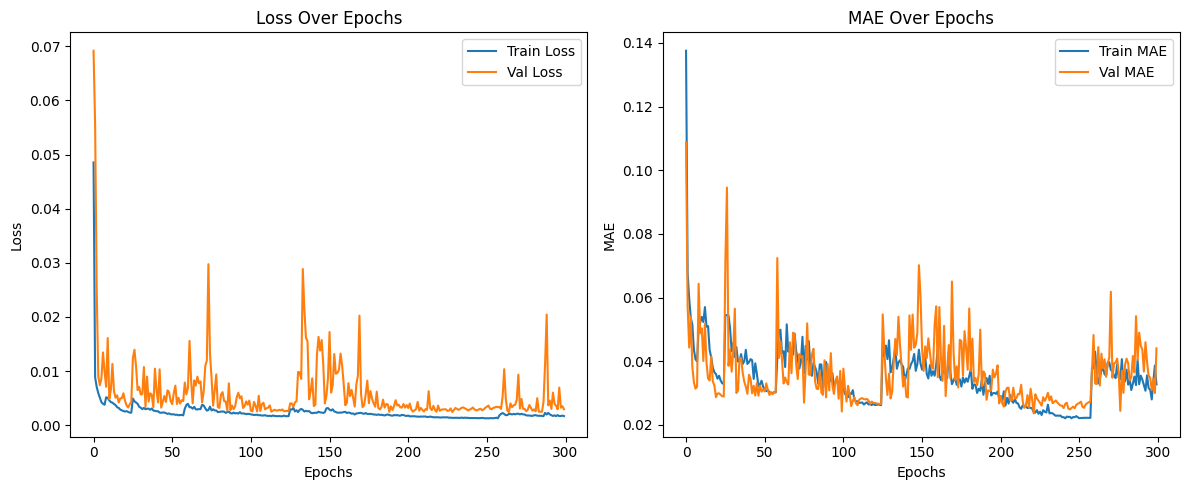

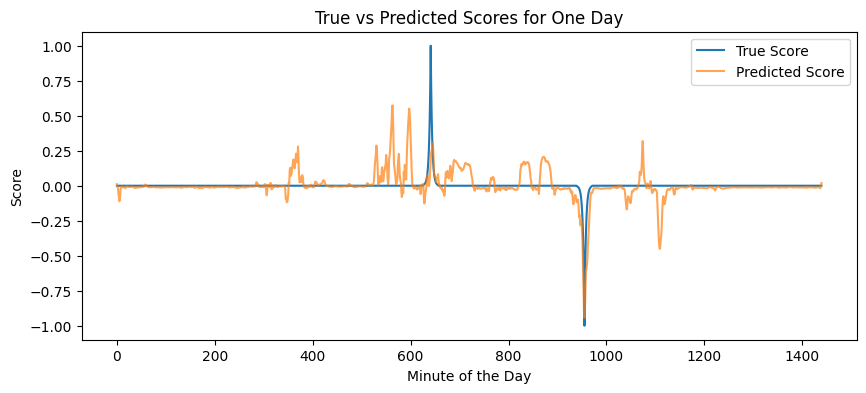

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, UpSampling1D,
                                     Dropout, BatchNormalization, concatenate,
                                     MultiHeadAttention, Add, LayerNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# --- Data Preparation ---
features = []
targets = []

for _, row in buckets.iterrows():
    feature_matrix = np.column_stack([
        row['anglez_log_ewma'],
        row['anglez_log_std'],
        row['anglez_log_mad'],
        row['enmo_ewma'],
        row['enmo_std'],
        row['anglez_std'],
        row['anglez_value_counts'],
        row['hour_sin'],
        row['hour_cos']
    ])
    features.append(feature_matrix)
    targets.append(row['target'])

X = np.array(features)
y = np.expand_dims(np.array(targets), axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Attention Block ---
def attention_block(x, num_heads=4):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)  # Dropout after attention
    return x

# --- 1D U-Net Model ---
def unet_1d_with_attention(input_shape):
    reg = None
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv1D(32, 5, activation='gelu', padding='same', kernel_regularizer=reg)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv1D(32, 5, activation='gelu', padding='same', kernel_regularizer=reg)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    drop1 = Dropout(0.2)(pool1)

    conv2 = Conv1D(64, 3, activation='gelu', padding='same', kernel_regularizer=reg)(drop1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(64, 3, activation='gelu', padding='same', kernel_regularizer=reg)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    drop2 = Dropout(0.3)(pool2)

    conv3 = Conv1D(128, 3, activation='gelu', padding='same', kernel_regularizer=reg)(drop2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv1D(128, 3, activation='gelu', padding='same', kernel_regularizer=reg)(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)
    drop3 = Dropout(0.4)(pool3)

    # Bottleneck
    conv4 = Conv1D(256, 3, activation='gelu', padding='same', kernel_regularizer=reg)(drop3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv1D(256, 3, activation='gelu', padding='same', kernel_regularizer=reg)(conv4)
    conv4 = BatchNormalization()(conv4)
    attn = attention_block(conv4, num_heads=4)

    # Decoder
    up3 = UpSampling1D(size=2)(attn)
    attn3 = attention_block(conv3, num_heads=4)
    merge3 = concatenate([up3, attn3])
    conv5 = Conv1D(128, 3, activation='gelu', padding='same', kernel_regularizer=reg)(merge3)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv1D(128, 3, activation='gelu', padding='same', kernel_regularizer=reg)(conv5)
    conv5 = BatchNormalization()(conv5)

    up2 = UpSampling1D(size=2)(conv5)
    merge2 = concatenate([up2, conv2])
    conv6 = Conv1D(64, 3, activation='gelu', padding='same', kernel_regularizer=reg)(merge2)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv1D(64, 3, activation='gelu', padding='same', kernel_regularizer=reg)(conv6)
    conv6 = BatchNormalization()(conv6)

    up1 = UpSampling1D(size=2)(conv6)
    merge1 = concatenate([up1, conv1])
    conv7 = Conv1D(32, 3, activation='gelu', padding='same', kernel_regularizer=reg)(merge1)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv1D(32, 3, activation='gelu', padding='same', kernel_regularizer=reg)(conv7)
    conv7 = BatchNormalization()(conv7)

    outputs = Conv1D(1, 1, activation='tanh')(conv7)

    return Model(inputs=inputs, outputs=outputs)

# --- Model Setup ---
n_time_steps = 1440
n_features = X.shape[2]
model = unet_1d_with_attention((n_time_steps, n_features))

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=1.0,
    alpha=1e-5
)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss=custom_loss_improved, metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# --- Evaluation & Save ---
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae:.4f}")

y_pred = model.predict(X_test)
model.save('models/unet1d_with_attention.keras')

# --- Plot History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Sample Prediction ---
sample_idx = 0
plt.figure(figsize=(10, 4))
plt.plot(y_test[sample_idx].flatten(), label='True Score')
plt.plot(y_pred[sample_idx].flatten(), label='Predicted Score', alpha=0.7)
plt.xlabel('Minute of the Day')
plt.ylabel('Score')
plt.title('True vs Predicted Scores for One Day')
plt.legend()
plt.show()

**For comparison**,  1000 epochs: the unet overfit - test loss start climbing after 300 epochs

Epoch 1/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - loss: 0.0883 - mae: 0.1946 - val_loss: 0.0624 - val_mae: 0.0745
Epoch 2/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0094 - mae: 0.0672 - val_loss: 0.0350 - val_mae: 0.0542
Epoch 3/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0070 - mae: 0.0645 - val_loss: 0.0196 - val_mae: 0.0536
Epoch 4/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0053 - mae: 0.0498 - val_loss: 0.0175 - val_mae: 0.0486
Epoch 5/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0051 - mae: 0.0532 - val_loss: 0.0179 - val_mae: 0.0556
Epoch 6/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0044 - mae: 0.0454 - val_loss: 0.0126 - val_mae: 0.0426
Epoch 7/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0041 - mae: 0.0428 - val_loss: 0.0133 - val_mae: 0.0410
Epoch 8/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0036 - mae: 0.0404 - val_loss: 0.0182 - val_mae: 0.0413
Epoch 9/1000
120/120 ━━━━━━━━━━

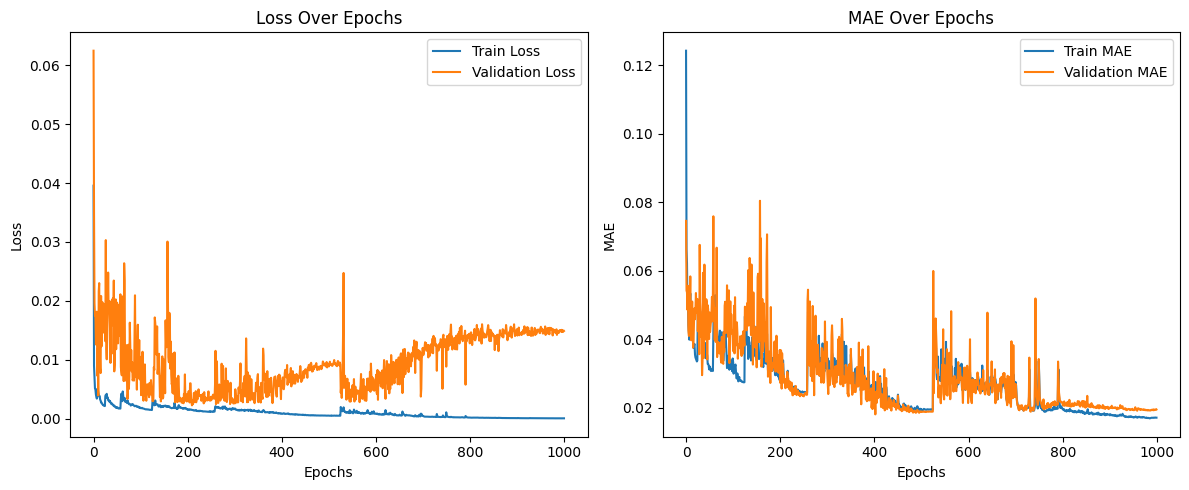

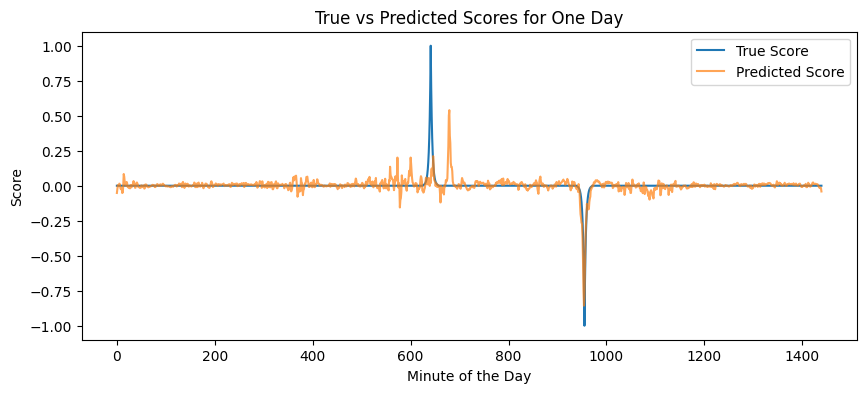

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, UpSampling1D,
                                     Dropout, BatchNormalization, concatenate,
                                     MultiHeadAttention, Add, LayerNormalization)

# --- Data Preparation (Assuming your buckets DataFrame is set up) ---
features = []
targets = []

for _, row in buckets.iterrows():
    # Each day's data: a 1440-length array for one day (features)
    feature_matrix = np.column_stack([
        row['anglez_log_ewma'],
        row['anglez_log_std'],
        row['anglez_log_mad'],
        row['enmo_ewma'],
        row['enmo_std'],
        row['anglez_std'],
        row['anglez_value_counts'],
        row['hour_sin'],
        row['hour_cos']
    ])
    features.append(feature_matrix)
    targets.append(row['target'])  # target is a 1440-length sequence of scores in [-1, 1]

X = np.array(features)  # shape: (n_samples, 1440, n_features)
y = np.array(targets)   # shape: (n_samples, 1440)
# Expand target dims to (n_samples, 1440, 1) for compatibility with our network output
y = np.expand_dims(y, axis=-1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Custom Loss Function: Combined Weighted MSE and Ranking Loss ---
def custom_loss_improved(y_true, y_pred):
    alpha = 6.0
    gamma = 2.0
    weight = 1 + alpha * K.abs(y_true)
    error = y_true - y_pred
    focal_weight = K.pow(K.abs(error), gamma)
    mse_loss = K.mean(weight * focal_weight * K.square(error))

    pos_mask = K.cast(K.greater(K.abs(y_true), 0.6), 'float32')
    neg_mask = 1.0 - pos_mask
    pos_count = K.sum(pos_mask) + K.epsilon()
    neg_count = K.sum(neg_mask) + K.epsilon()
    pos_mean = K.sum(K.abs(y_pred) * pos_mask) / pos_count
    neg_mean = K.sum(K.abs(y_pred) * neg_mask) / neg_count
    margin = 0.6
    ranking_loss = K.relu(margin - (pos_mean - neg_mean))

    return mse_loss + 0.1 * ranking_loss


# --- Build a 1D U-Net Model ---
def attention_block(x, num_heads=4):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)
    return x

def unet_1d_with_attention(input_shape):
    inputs = Input(shape=input_shape)

    # --- Downsampling path ---
    # Block 1
    conv1 = Conv1D(32, kernel_size=5, activation='gelu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv1D(32, kernel_size=5, activation='gelu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    drop1 = Dropout(0.2)(pool1)

    # Block 2
    conv2 = Conv1D(64, kernel_size=3, activation='gelu', padding='same')(drop1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(64, kernel_size=3, activation='gelu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    drop2 = Dropout(0.3)(pool2)

    # Block 3
    conv3 = Conv1D(128, kernel_size=3, activation='gelu', padding='same')(drop2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv1D(128, kernel_size=3, activation='gelu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)
    drop3 = Dropout(0.4)(pool3)

    # --- Bottleneck with Attention ---
    conv4 = Conv1D(256, kernel_size=3, activation='gelu', padding='same')(drop3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv1D(256, kernel_size=3, activation='gelu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Add attention block
    attn = attention_block(conv4, num_heads=4)

    # --- Upsampling path ---
    up3 = UpSampling1D(size=2)(attn)
    attn3 = attention_block(conv3, num_heads=4)
    merge3 = concatenate([up3, attn3])
    conv5 = Conv1D(128, kernel_size=3, activation='gelu', padding='same')(merge3)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv1D(128, kernel_size=3, activation='gelu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up2 = UpSampling1D(size=2)(conv5)
    merge2 = concatenate([up2, conv2])
    conv6 = Conv1D(64, kernel_size=3, activation='gelu', padding='same')(merge2)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv1D(64, kernel_size=3, activation='gelu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up1 = UpSampling1D(size=2)(conv6)
    merge1 = concatenate([up1, conv1])
    conv7 = Conv1D(32, kernel_size=3, activation='gelu', padding='same')(merge1)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv1D(32, kernel_size=3, activation='gelu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Output layer: single channel with tanh activation for scores in [-1, 1]
    outputs = Conv1D(1, kernel_size=1, activation='tanh')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create U-Net model with input shape (1440, n_features)
n_time_steps = 1440
n_features = X.shape[2]
model = unet_1d_with_attention((n_time_steps, n_features))

# Compile model using an adaptable learning rate if desired
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=1.0,
    alpha=1e-5
)

optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=custom_loss_improved, metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae:.4f}")

# Make predictions
y_pred = model.predict(X_test)

# Save the model
model.save('unet1d_with_attention.keras')
import shutil
shutil.move("/content/unet1d_with_attention.keras", "/content/drive/My Drive/WorkshopML/models/exp score/unet1d_with_attention_exp_score_improved_loss.keras")

# --- Plot training history ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# --- Optionally, visualize a sample prediction vs. ground truth ---
sample_idx = 0
plt.figure(figsize=(10, 4))
plt.plot(y_test[sample_idx].flatten(), label='True Score')
plt.plot(y_pred[sample_idx].flatten(), label='Predicted Score', alpha=0.7)
plt.xlabel('Minute of the Day')
plt.ylabel('Score')
plt.title('True vs Predicted Scores for One Day')
plt.legend()
plt.show()

# lstm with attention - second best model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LSTM, Bidirectional, Dense, Dropout,
                                     BatchNormalization, TimeDistributed, Attention,
                                     concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import shutil
from tensorflow.keras.callbacks import ModelCheckpoint

# --- Data Preparation ---
features = []
targets = []

for _, row in buckets.iterrows():
    feature_matrix = np.column_stack([
        row['anglez_log_ewma'],
        row['anglez_log_std'],
        row['anglez_log_mad'],
        row['enmo_ewma'],
        row['enmo_std'],
        row['anglez_std'],
        row['anglez_value_counts'],
        row['hour_sin'],
        row['hour_cos']
    ])
    features.append(feature_matrix)
    targets.append(row['target'])

X = np.array(features)
y = np.expand_dims(np.array(targets), axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Custom Loss ---
def custom_loss_improved(y_true, y_pred):
    # Weighted focal MSE
    alpha = 6.0
    gamma = 2.0
    weight = 1 + alpha * K.abs(y_true)
    error = y_true - y_pred
    focal_weight = K.pow(K.abs(error), gamma)
    mse_loss = K.mean(weight * focal_weight * K.square(error))

    # Ranking loss
    pos_mask = K.cast(K.greater(K.abs(y_true), 0.6), 'float32')
    neg_mask = 1.0 - pos_mask
    pos_count = K.sum(pos_mask) + K.epsilon()
    neg_count = K.sum(neg_mask) + K.epsilon()
    pos_mean = K.sum(K.abs(y_pred) * pos_mask) / pos_count
    neg_mean = K.sum(K.abs(y_pred) * neg_mask) / neg_count
    margin = 0.6
    ranking_loss = K.relu(margin - (pos_mean - neg_mean))

    return mse_loss + 0.1 * ranking_loss

# --- LSTM Model with Attention ---
def lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder-like LSTM stack
    x = LSTM(32, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = LSTM(32, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Self-attention (additive)
    attn_output = Attention()([x, x])  # shape: (batch, time, features)
    x = concatenate([x, attn_output])

    # Decoder-like dense layers
    x = TimeDistributed(Dense(64, activation='gelu'))(x)
    x = TimeDistributed(Dense(32, activation='gelu'))(x)
    outputs = TimeDistributed(Dense(1, activation='tanh'))(x)

    return Model(inputs=inputs, outputs=outputs)

# --- Model Setup ---
n_time_steps = 1440
n_features = X.shape[2]
model = lstm_model((n_time_steps, n_features))

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=1.0,
    alpha=1e-5
)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss=custom_loss_improved, metrics=['mae'])

# --- Train with EarlyStopping ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

checkpoint_path = "/content/drive/MyDrive/WorkshopML/models/checkpoints/lstm_best_weights.weights.h5"

checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=4,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, checkpoint_cb]
)

# --- Evaluation & Save ---
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae:.4f}")

y_pred = model.predict(X_test)
model.save('models/lstm_with_attention.keras')

# --- Plot History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Sample Prediction ---
sample_idx = 0
plt.figure(figsize=(10, 4))
plt.plot(y_test[sample_idx].flatten(), label='True Score')
plt.plot(y_pred[sample_idx].flatten(), label='Predicted Score', alpha=0.7)
plt.xlabel('Minute of the Day')
plt.ylabel('Score')
plt.title('True vs Predicted Scores for One Day')
plt.legend()
plt.show()


Epoch 1/70
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - loss: 0.0627 - mae: 0.1612
Epoch 1: val_loss improved from inf to 0.02033, saving model to /content/drive/MyDrive/WorkshopML/models/checkpoints/lstm_best_weights.weights.h5
960/960 ━━━━━━━━━━━━━━━━━━━━ 982s 685ms/step - loss: 0.0627 - mae: 0.1612 - val_loss: 0.0203 - val_mae: 0.0727
Epoch 2/70
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 0.0203 - mae: 0.0802
Epoch 2: val_loss improved from 0.02033 to 0.01329, saving model to /content/drive/MyDrive/WorkshopML/models/checkpoints/lstm_best_weights.weights.h5
960/960 ━━━━━━━━━━━━━━━━━━━━ 579s 603ms/step - loss: 0.0203 - mae: 0.0802 - val_loss: 0.0133 - val_mae: 0.0411
Epoch 3/70
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - loss: 0.0131 - mae: 0.0571
Epoch 3: val_loss improved from 0.01329 to 0.01042, saving model to /content/drive/MyDrive/WorkshopML/models/checkpoints/lstm_best_weights.weights.h5
960/960 ━━━━━━━━━━━━━━━━━━━━ 576s 600ms/step - loss: 0.0131 - mae: 0.0571 - val_los

For visualization of training

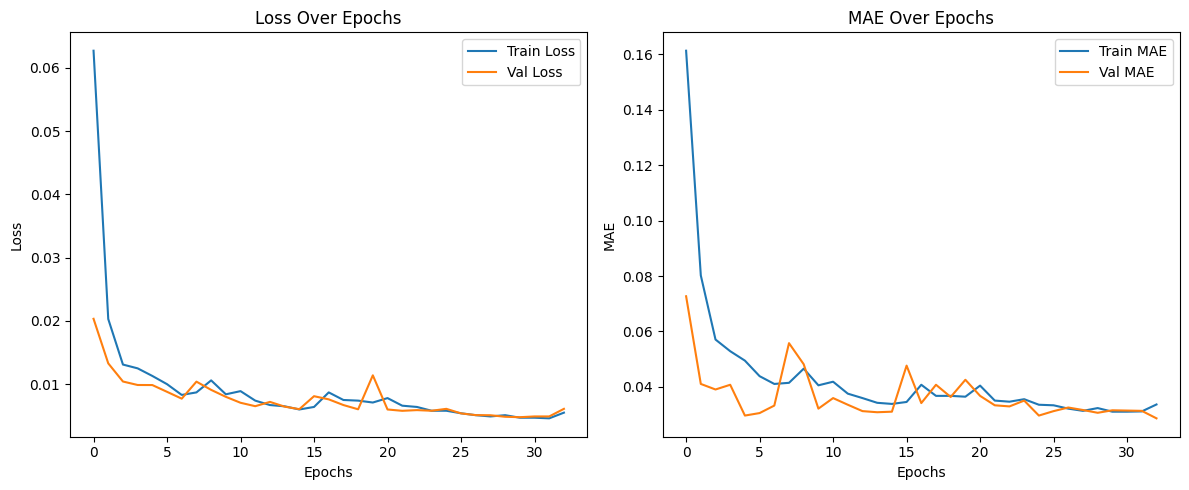

In [ ]:
import matplotlib.pyplot as plt

# --- Data ---
history_dict = {
    'loss': [
        0.0627, 0.0203, 0.0131, 0.0125, 0.0113, 0.0100, 0.0083, 0.0087, 0.0106,
        0.0084, 0.0089, 0.0074, 0.0067, 0.0065, 0.0060, 0.0064, 0.0087, 0.0075,
        0.0074, 0.0071, 0.0078, 0.0066, 0.0064, 0.0058, 0.0058, 0.0054, 0.0051,
        0.0049, 0.0051, 0.0047, 0.0047, 0.0046, 0.0055
    ],
    'val_loss': [
        0.02033, 0.01329, 0.01042, 0.00987, 0.00986, 0.00879, 0.00771, 0.0104, 0.0091,
        0.0080, 0.00706, 0.00652, 0.0072, 0.00645, 0.00605, 0.0081, 0.0076, 0.0067,
        0.00603, 0.0114, 0.0060, 0.00579, 0.0059, 0.0058, 0.0061, 0.00538, 0.00511,
        0.00509, 0.00485, 0.00478, 0.0049, 0.0049, 0.0061
    ],
    'mae': [
        0.1612, 0.0802, 0.0571, 0.0529, 0.0495, 0.0439, 0.0411, 0.0415, 0.0466,
        0.0406, 0.0419, 0.0376, 0.0360, 0.0343, 0.0339, 0.0346, 0.0408, 0.0368,
        0.0368, 0.0365, 0.0405, 0.0351, 0.0347, 0.0356, 0.0336, 0.0334, 0.0322,
        0.0314, 0.0324, 0.0311, 0.0311, 0.0312, 0.0337
    ],
    'val_mae': [
        0.0727, 0.0411, 0.0391, 0.0408, 0.0297, 0.0306, 0.0333, 0.0558, 0.0482,
        0.0322, 0.0360, 0.0336, 0.0313, 0.0309, 0.0311, 0.0477, 0.0342, 0.0408,
        0.0364, 0.0426, 0.0368, 0.0334, 0.0330, 0.0351, 0.0297, 0.0313, 0.0326,
        0.0317, 0.0307, 0.0316, 0.0315, 0.0314, 0.0287
    ]
}

# --- Plot History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

For visualization of performance

30/30 ━━━━━━━━━━━━━━━━━━━━ 105s 828ms/step


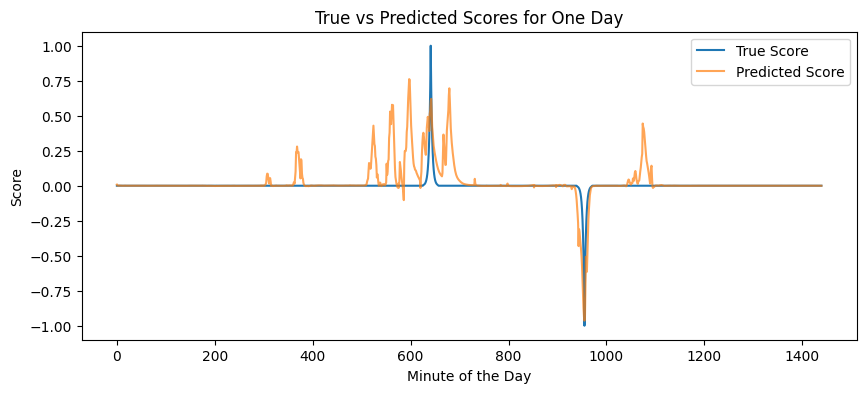

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = model.predict(X_test)

# --- Plot Sample Prediction ---
sample_idx = 0
plt.figure(figsize=(10, 4))
plt.plot(y_test[sample_idx].flatten(), label='True Score')
plt.plot(y_pred[sample_idx].flatten(), label='Predicted Score', alpha=0.7)
plt.xlabel('Minute of the Day')
plt.ylabel('Score')
plt.title('True vs Predicted Scores for One Day')
plt.legend()
plt.show()


# Temporal Convolutional Network (TCN)

Epoch 1/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - loss: 0.1387 - mae: 0.2245 - val_loss: 0.0552 - val_mae: 0.0816
Epoch 2/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0514 - mae: 0.1599 - val_loss: 0.0379 - val_mae: 0.0648
Epoch 3/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0286 - mae: 0.1149 - val_loss: 0.0249 - val_mae: 0.0746
Epoch 4/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0161 - mae: 0.0864 - val_loss: 0.0199 - val_mae: 0.0878
Epoch 5/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0142 - mae: 0.0756 - val_loss: 0.0140 - val_mae: 0.0746
Epoch 6/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0117 - mae: 0.0676 - val_loss: 0.0128 - val_mae: 0.0579
Epoch 7/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0109 - mae: 0.0634 - val_loss: 0.0105 - val_mae: 0.0549
Epoch 8/1000
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0098 - mae: 0.0629 - val_loss: 0.0097 - val_mae: 0.0573
Epoch 9/1000
120/120 ━━━━━━━━━━

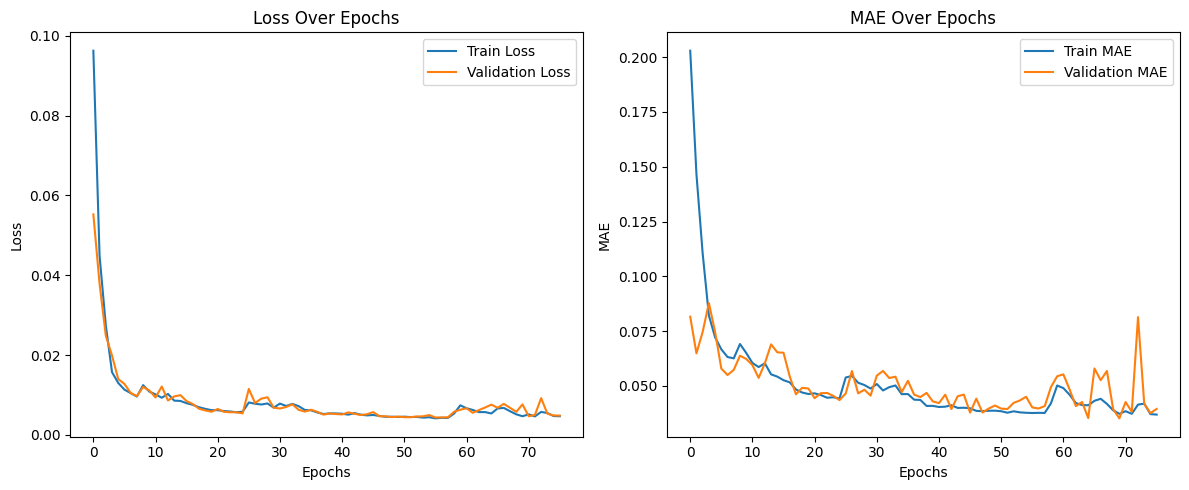

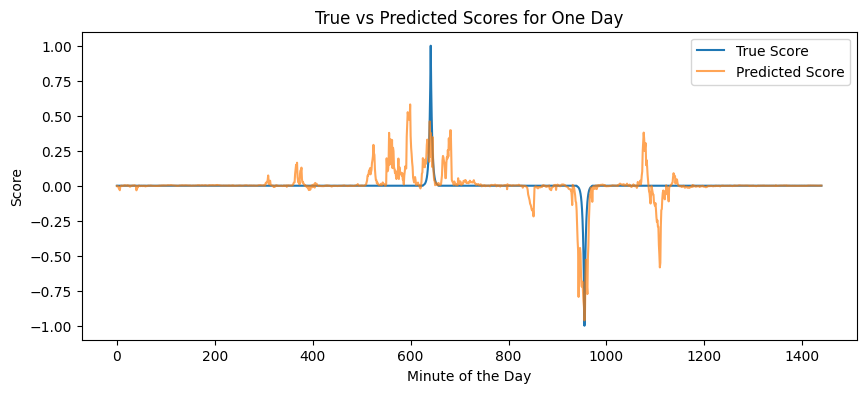

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, UpSampling1D,
                                     Dropout, BatchNormalization, concatenate,
                                     MultiHeadAttention, Add, LayerNormalization)
from tensorflow.keras.layers import Layer, Activation, Lambda
from tensorflow.keras.callbacks import EarlyStopping


class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, dropout_rate=0.2):
        super().__init__()
        self.conv1 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)
        self.bn1 = BatchNormalization()
        self.act1 = Activation('gelu')
        self.drop1 = Dropout(dropout_rate)

        self.conv2 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)
        self.bn2 = BatchNormalization()
        self.act2 = Activation('gelu')
        self.drop2 = Dropout(dropout_rate)

        self.residual = Conv1D(filters, 1, padding='same')  # project input if needed

    def call(self, x):
        res = self.residual(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.drop2(x)

        return tf.keras.activations.gelu(x + res)
# --- Data Preparation  ---
features = []
targets = []

for _, row in buckets.iterrows():
    # Each day's data: a 1440-length array for one day (features)
    feature_matrix = np.column_stack([
        row['anglez_log_ewma'],
        row['anglez_log_std'],
        row['anglez_log_mad'],
        row['enmo_ewma'],
        row['enmo_std'],
        row['anglez_std'],
        row['anglez_value_counts'],
        row['hour_sin'],
        row['hour_cos']
    ])
    features.append(feature_matrix)
    targets.append(row['target'])  # target is a 1440-length sequence of scores in [-1, 1]

X = np.array(features)  # shape: (n_samples, 1440, n_features)
y = np.array(targets)   # shape: (n_samples, 1440)
# Expand target dims to (n_samples, 1440, 1) for compatibility with our network output
y = np.expand_dims(y, axis=-1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_tcn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = inputs

    # Stack of residual dilated conv blocks
    for i, dilation_rate in enumerate([1, 2, 4, 8, 16, 32]):
        x = ResidualBlock(filters=64, kernel_size=3, dilation_rate=dilation_rate)(x)

    # Final Conv1D to map to 1 output per time step
    outputs = Conv1D(1, kernel_size=1, activation='tanh')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

n_time_steps = 1440
n_features = X.shape[2]


lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=1.0,
    alpha=1e-5
)

optimizer = Adam(learning_rate=lr_schedule)

tcn_model = build_tcn_model((n_time_steps, n_features))
tcn_model.compile(optimizer=optimizer, loss=custom_loss_improved, metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)
history = tcn_model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


# Evaluate the model
test_loss, test_mae = tcn_model.evaluate(X_test, y_test, verbose=0)
print(f"TCN Test MAE: {test_mae:.4f}")

# Make predictions
y_pred = tcn_model.predict(X_test)

# Save the model
tcn_model.save('unet1d_with_attention.keras')
import shutil
shutil.move("/content/unet1d_with_attention.keras", "/content/drive/My Drive/WorkshopML/models/exp score/tcn_exp_score_improved_loss.keras")

# --- Plot training history ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# --- visualize a sample prediction vs. ground truth ---
sample_idx = 0
plt.figure(figsize=(10, 4))
plt.plot(y_test[sample_idx].flatten(), label='True Score')
plt.plot(y_pred[sample_idx].flatten(), label='Predicted Score', alpha=0.7)
plt.xlabel('Minute of the Day')
plt.ylabel('Score')
plt.title('True vs Predicted Scores for One Day')
plt.legend()
plt.show()

# transformer

Epoch 1/400
120/120 ━━━━━━━━━━━━━━━━━━━━ 122s 822ms/step - loss: 0.1334 - mae: 0.2625 - val_loss: 0.0584 - val_mae: 0.1218
Epoch 2/400
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 805ms/step - loss: 0.0588 - mae: 0.1542 - val_loss: 0.0520 - val_mae: 0.1386
Epoch 3/400
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 803ms/step - loss: 0.0548 - mae: 0.1457 - val_loss: 0.0499 - val_mae: 0.1347
Epoch 4/400
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 802ms/step - loss: 0.0506 - mae: 0.1386 - val_loss: 0.0472 - val_mae: 0.1243
Epoch 5/400
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 803ms/step - loss: 0.0493 - mae: 0.1348 - val_loss: 0.0471 - val_mae: 0.1104
Epoch 6/400
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 805ms/step - loss: 0.0479 - mae: 0.1286 - val_loss: 0.0443 - val_mae: 0.1206
Epoch 7/400
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 805ms/step - loss: 0.0447 - mae: 0.1285 - val_loss: 0.0447 - val_mae: 0.1205
Epoch 8/400
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 806ms/step - loss: 0.0423 - mae: 0.1249 - val_loss: 0.0403 - val_mae: 0.1175
Epoch 9/400
120/120 ━━━

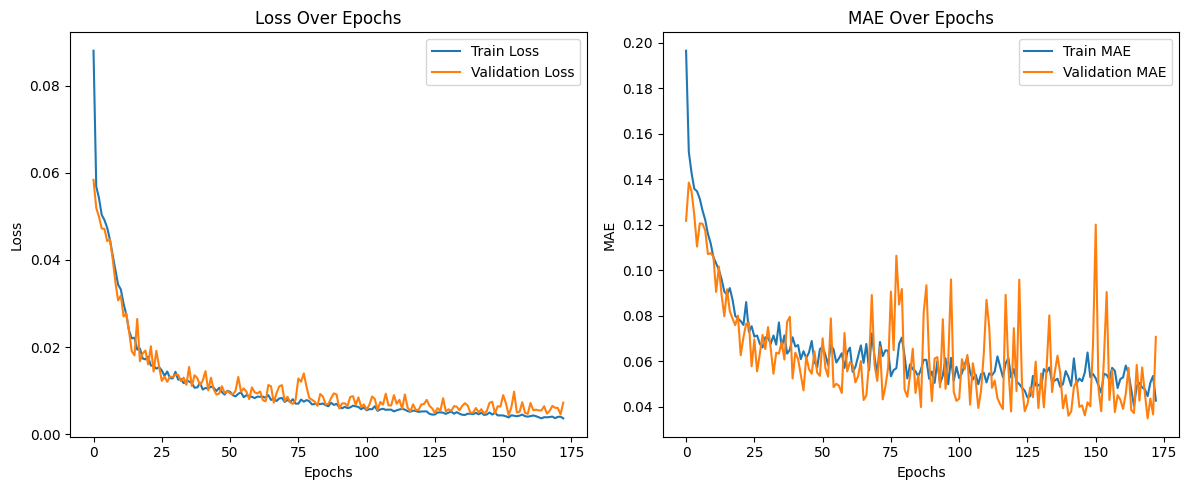

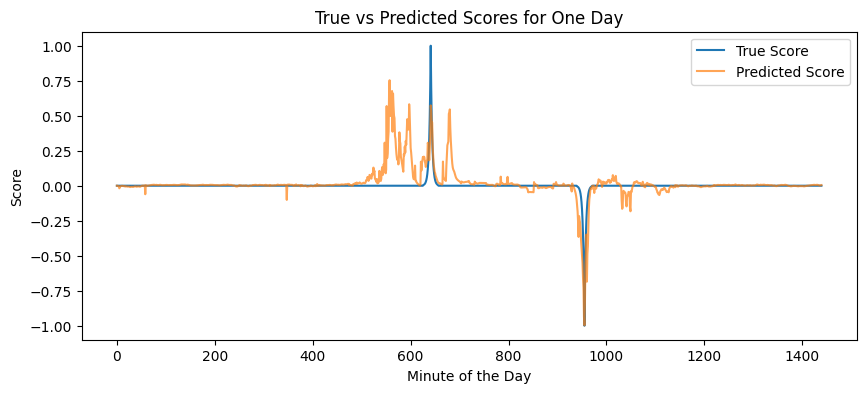

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, UpSampling1D,
                                     Dropout, BatchNormalization, concatenate,
                                     MultiHeadAttention, Add, LayerNormalization)
from tensorflow.keras.layers import Layer, Activation, Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping



class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_len, d_model):
        super().__init__()
        position = np.arange(sequence_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = np.zeros((sequence_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :]

def transformer_encoder_block(x, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head self-attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)

    # Feed-forward
    ff = tf.keras.Sequential([
        Dense(ff_dim, activation='gelu'),
        Dropout(dropout_rate),
        Dense(x.shape[-1]),
    ])
    ff_output = ff(x)
    x = Add()([x, ff_output])
    x = LayerNormalization()(x)
    return x

# --- Data Preparation ---
features = []
targets = []

for _, row in buckets.iterrows():
    # Each day's data: a 1440-length array for one day (features)
    feature_matrix = np.column_stack([
        row['anglez_log_ewma'],
        row['anglez_log_std'],
        row['anglez_log_mad'],
        row['enmo_ewma'],
        row['enmo_std'],
        row['anglez_std'],
        row['anglez_value_counts'],
        row['hour_sin'],
        row['hour_cos']
    ])
    features.append(feature_matrix)
    targets.append(row['target'])  # target is a 1440-length sequence of scores in [-1, 1]

X = np.array(features)  # shape: (n_samples, 1440, n_features)
y = np.array(targets)   # shape: (n_samples, 1440)
# Expand target dims to (n_samples, 1440, 1) for compatibility with our network output
y = np.expand_dims(y, axis=-1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Custom Loss Function: Combined Weighted MSE and Ranking Loss ---
def custom_loss_improved(y_true, y_pred):
    # Weighted focal MSE
    alpha = 6.0
    gamma = 2.0
    weight = 1 + alpha * K.abs(y_true)
    error = y_true - y_pred
    focal_weight = K.pow(K.abs(error), gamma)
    mse_loss = K.mean(weight * focal_weight * K.square(error))

    pos_mask = K.cast(K.greater(K.abs(y_true), 0.6), 'float32')
    neg_mask = 1.0 - pos_mask
    pos_count = K.sum(pos_mask) + K.epsilon()
    neg_count = K.sum(neg_mask) + K.epsilon()
    pos_mean = K.sum(K.abs(y_pred) * pos_mask) / pos_count
    neg_mean = K.sum(K.abs(y_pred) * neg_mask) / neg_count
    margin = 0.6
    ranking_loss = K.relu(margin - (pos_mean - neg_mean))

    return mse_loss + 0.1 * ranking_loss

def build_transformer_model(input_shape, num_layers=4, num_heads=4, ff_dim=128):
    inputs = Input(shape=input_shape)

    x = Dense(128)(inputs)

    # Add positional encoding
    x = PositionalEncoding(sequence_len=input_shape[0], d_model=128)(x)

    # Transformer blocks
    for _ in range(num_layers):
        x = transformer_encoder_block(x, num_heads=num_heads, ff_dim=ff_dim)

    # Final projection to 1 output per time step
    outputs = Dense(1, activation='tanh')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


n_time_steps = 1440
n_features = X.shape[2]



# Compile model using an adaptable learning rate if desired
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=1.0,
    alpha=1e-5
)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
# Create and compile model
transformer_model = build_transformer_model((n_time_steps, n_features))
transformer_model.compile(optimizer=optimizer, loss=custom_loss_improved, metrics=['mae'])

# Train the model
history = transformer_model.fit(X_train, y_train,
                                   epochs=400,
                                   batch_size=32,
                                   validation_data=(X_test, y_test), callbacks=[early_stopping])


# Evaluate the model
test_loss_tf, test_mae_tf = transformer_model.evaluate(X_test, y_test, verbose=0)
print(f"Transformer Test MAE: {test_mae_tf:.4f}")

# Make predictions
y_pred = transformer_model.predict(X_test)

# Save the model
transformer_model.save('unet1d_with_attention.keras')
import shutil
shutil.move("/content/unet1d_with_attention.keras", "/content/drive/My Drive/WorkshopML/models/exp score/transformer_exp_score_improved_loss.keras")

# --- Plot training history ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# --- visualize a sample prediction vs. ground truth ---
sample_idx = 0
plt.figure(figsize=(10, 4))
plt.plot(y_test[sample_idx].flatten(), label='True Score')
plt.plot(y_pred[sample_idx].flatten(), label='Predicted Score', alpha=0.7)
plt.xlabel('Minute of the Day')
plt.ylabel('Score')
plt.title('True vs Predicted Scores for One Day')
plt.legend()
plt.show()